In [ ]:
# Copyright 2023-2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Gemini in Education

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Feducation%2Fuse_cases_for_education.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


|           |                                                  |
| --------- | ------------------------------------------------ |
| Author(s) | [Laurent Picard](https://github.com/PicardParis) |


## Overview

In this notebook, you will explore a variety of use cases enabled by Gemini 1.5 in the context of education.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind.

### Gemini 1.5

The Gemini 1.5 models are built for multimodality from the ground up:

- Supported inputs: Text, code, images, audio, video, video with audio, and PDF
- Generated output: Text

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with the Gemini models. There are currently two Gemini 1.5 models available using the Gemini API:

- **Gemini 1.5 Flash** (`gemini-1.5-flash-001`) for fast and versatile performance across a diverse variety of tasks
- **Gemini 1.5 Pro** (`gemini-1.5-pro-001`) for complex reasoning tasks such as code and text generation, text editing, problem solving, data extraction and generation

For more information, see [Gemini models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#gemini-models).


### Objectives

The main objective of this notebook is to demonstrate a variety of educational use cases that can benefit from Gemini 1.5.

The steps performed include:

- Installing the Python SDK
- Loading Gemini
- Reasoning at different levels
- Reasoning on text
- Reasoning on numbers
- Reasoning on a single image
- Reasoning on multiple images
- Reasoning on a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.


In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:


In [1]:
# Define project information
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import Vertex AI classes


In [2]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Image,
    Part,
)

### Define helper functions

Define some helper functions to load and display images.


In [3]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


Contents = str | list[str | Image | Part]


def generate_content(
    model: GenerativeModel,
    contents: Contents,
    temperature: float = 0.0,
) -> GenerationResponse:
    """Call the Vertex AI Gemini API.

    The default temperature (randomness/creativity) is set low for more consistent responses.
    """
    generation_config = GenerationConfig(
        temperature=temperature,
        candidate_count=1,
        max_output_tokens=8192,
    )
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

    response = model.generate_content(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
    assert isinstance(response, GenerationResponse)

    return response


def print_contents(contents: Contents):
    """Print the full contents for ease of readability."""
    if not isinstance(contents, list):
        contents = [contents]

    print(" Contents ".center(80, "-"))
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_image(content)
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    cloud_storage_path = content.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{cloud_storage_path}"
    html = IPython.display.HTML(f'<a href="{video_url}">Video:</a>')
    video = IPython.display.Video(
        url=video_url,
        width=600,
        html_attributes="controls muted",
    )
    IPython.display.display(html)
    IPython.display.display(video)

    return True


def print_response(response: GenerationResponse, as_markdown: bool = True):
    # Remove potential leading/trailing spaces
    text = response.text.strip()

    print(" Start of response ".center(80, "-"))
    if as_markdown:
        IPython.display.display(IPython.display.Markdown(text))
    else:
        print(text)
    print(" End of response ".center(80, "-"))
    print("")


def display_image(image: Image, max_width: int = 600, max_height: int = 350):
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image):
    """Display the image in a compressed format to reduce the notebook size."""
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

## Loading Gemini 1.5

Both Gemini 1.5 Pro and Gemini 1.5 Flash excel at education use cases. Here are the selection factors to consider:

- Gemini 1.5 Pro (larger model): quality and complexity
- Gemini 1.5 Flash (smaller model): speed and cost

> Gemini 1.5 Flash is trained by Gemini 1.5 Pro through a process called "distillation" where the larger model transfers its most essential knowledge and skills to the smaller model.


In [4]:
model_name = "gemini-1.5-pro-001"
# model_name = "gemini-1.5-flash-001"

model = GenerativeModel(model_name)

## Reasoning at different levels


You can ask for direct answers:


In [5]:
contents = """
What happened to the dinosaurs? When?
Explain simply in one sentence.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

What happened to the dinosaurs? When?
Explain simply in one sentence.

------------------------------ Start of response -------------------------------


Dinosaurs went extinct about 66 million years ago when an asteroid hit Earth, causing catastrophic environmental changes.

------------------------------- End of response --------------------------------



… as well as for more nuanced answers:


In [6]:
contents = """
Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.

------------------------------ Start of response -------------------------------


No, we are not 100% sure about what happened to the dinosaurs. While the **impact of a large asteroid or comet** is widely accepted as the most likely primary cause of the extinction event that wiped out the dinosaurs (except for birds), there are still uncertainties and other contributing factors being researched. 

Here's a breakdown of the current main hypotheses:

**1. The Impact Event:**

* **What we know:**  A massive asteroid or comet, estimated to be about 6 miles wide, struck the Earth near the Yucatán Peninsula in Mexico around 66 million years ago. This impact created the Chicxulub crater, which is 110 miles in diameter and 12 miles deep.
* **Evidence:** The presence of a global layer of iridium (rare on Earth but abundant in asteroids) in rock strata dating back to the extinction event, shocked quartz (formed under intense pressure), and the Chicxulub crater itself.
* **Effects:** The impact would have triggered catastrophic events like:
    * **Massive earthquakes and tsunamis:** Devastating coastal regions and causing widespread destruction.
    * **Global wildfires:** Ejecting superheated rock and dust into the atmosphere, igniting wildfires across the globe.
    * **Atmospheric dust and soot:** Blocking sunlight, leading to a prolonged period of darkness and global cooling (impact winter).
    * **Acid rain:** Releasing sulfur dioxide into the atmosphere, leading to widespread acid rain that would have acidified oceans and soils.

**2. Deccan Traps Volcanism:**

* **What we know:** Around the same time as the impact, massive volcanic eruptions were occurring in what is now India, forming the Deccan Traps. These eruptions released enormous amounts of lava and gases like sulfur dioxide and carbon dioxide into the atmosphere.
* **Evidence:**  The Deccan Traps lava flows are dated to around the same time as the extinction event.
* **Effects:** Volcanic activity could have contributed to the extinction by:
    * **Climate change:** Releasing greenhouse gases, leading to global warming and ocean acidification.
    * **Acid rain:** Similar to the impact, releasing sulfur dioxide into the atmosphere.
* **Debate:**  The exact role of the Deccan Traps in the extinction is still debated. Some scientists believe it may have weakened ecosystems before the impact, making them more vulnerable, while others argue its effects were less significant than the impact itself.

**3. Gradual Environmental Change:**

* **What we know:**  The Earth's climate and environment were already undergoing changes in the millions of years leading up to the extinction event, such as sea level fluctuations and volcanic activity.
* **Evidence:** Fossil records show a decline in dinosaur diversity in some regions before the impact.
* **Effects:** These changes may have stressed dinosaur populations, making them more susceptible to extinction from a catastrophic event.

**Current Consensus:**

The most widely accepted hypothesis is that the asteroid impact was the primary cause of the dinosaur extinction, with the Deccan Traps volcanism potentially playing a contributing role. The impact's immediate and catastrophic effects, combined with the long-term environmental consequences, likely led to the demise of the dinosaurs and many other species.

**Ongoing Research:**

Scientists continue to investigate the details of the extinction event, including:

* The exact timing and duration of the impact's effects.
* The relative contributions of the impact and volcanism.
* The specific mechanisms by which different species went extinct.

While we may never know with 100% certainty what happened to the dinosaurs, ongoing research continues to refine our understanding of this pivotal event in Earth's history.

------------------------------- End of response --------------------------------



You can ask for simple answers:


In [7]:
contents = """
Explain why it's summer here in France and winter in Australia.
I'm a kid. Answer in simple key points.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Explain why it's summer here in France and winter in Australia.
I'm a kid. Answer in simple key points.

------------------------------ Start of response -------------------------------


Okay, imagine the Earth is like a spinning top:

* **Tilted Top:** The Earth isn't straight up and down, it's a little tilted on its side.
* **Sun's Rays:**  The sun's rays hit different parts of the tilted Earth more directly at different times of the year.
* **Summertime Tilt:** During France's summer, the top part of the Earth (where France is) is tilted towards the sun, getting more direct sunlight and heat.
* **Wintertime Tilt:** At the same time, the bottom part of the Earth (where Australia is) is tilted away from the sun, getting less direct sunlight and making it winter there. 
* **Switching Places:**  As the Earth travels around the sun, the tilt means different parts get more direct sunlight.  So when it's summer in France, it's winter in Australia, and then they switch!

------------------------------- End of response --------------------------------



… or for more detailed answers:


In [8]:
contents = """
Explain why we have tides.
I'm a scientist. Provide a detailed answer using bullet points.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Explain why we have tides.
I'm a scientist. Provide a detailed answer using bullet points.

------------------------------ Start of response -------------------------------


Tides are the periodic rise and fall of ocean water levels, primarily caused by the gravitational forces exerted by the Moon and the Sun on the Earth. Here's a detailed explanation:

**Gravitational Forces:**

* **Moon's Gravity:** The Moon's gravitational pull is the primary cause of tides. The Moon's gravity pulls the water on the side of Earth closest to it, creating a bulge of water (high tide).
* **Centrifugal Force:**  On the opposite side of the Earth, the inertia of the water (its tendency to keep moving in a straight line) is greater than the Moon's gravitational pull. This creates another bulge of water (high tide) on the side farthest from the Moon.
* **Sun's Influence:** The Sun also exerts a gravitational force on Earth, but its effect on tides is weaker than the Moon's because it's much farther away. However, when the Sun, Earth, and Moon are aligned (during new and full moons), their gravitational forces combine to produce higher high tides and lower low tides, known as **spring tides**.
* **Neap Tides:** When the Sun, Earth, and Moon form a right angle (during the first and third quarter moons), the Sun's gravitational pull partially counteracts the Moon's pull. This results in lower high tides and higher low tides, known as **neap tides**.

**Other Factors:**

* **Earth's Rotation:** As the Earth rotates, different locations on Earth pass through the tidal bulges created by the Moon and Sun, experiencing high and low tides.
* **Shape of Coastlines:** The shape of coastlines and the depth of the ocean floor can influence the height and timing of tides. Bays and estuaries can amplify tidal ranges, while islands and shallow water can create complex tidal patterns.
* **Weather:**  Strong winds and changes in atmospheric pressure can also affect local tide heights.

**In summary:**

Tides are a complex interplay of gravitational forces from the Moon and Sun, Earth's rotation, and geographical factors. The Moon's gravitational pull is the dominant force, creating two tidal bulges on opposite sides of the Earth. The Sun's influence modifies the intensity of these tides, leading to spring and neap tides.

------------------------------- End of response --------------------------------



You can ask closed questions:


In [9]:
contents = """
When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.

------------------------------ Start of response -------------------------------


Here's the information:

* **Previous leap year:** 2020
* **Penultimate leap year:** 2016

**3 International Competitions in 2016:**

1. **Summer Olympics**
    * **Dates:** August 5 - August 21, 2016
    * **City:** Rio de Janeiro, Brazil
    * **Venues:** Various, including Maracanã Stadium (ceremonies, soccer), Olympic Aquatics Stadium (swimming, diving, synchronized swimming), Olympic Park (multiple sports)

2. **UEFA European Championship (UEFA Euro 2016)**
    * **Dates:** June 10 - July 10, 2016
    * **City:** Various cities in France
    * **Venues:** Stade de France (Saint-Denis), Parc des Princes (Paris), Stade Vélodrome (Marseille), and others

3. **World Economic Forum (WEF) Annual Meeting**
    * **Dates:** January 20 - 23, 2016
    * **City:** Davos, Switzerland
    * **Venue:** Davos Congress Centre

------------------------------- End of response --------------------------------



… as well as questions that are more open:


In [10]:
contents = """
What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.

------------------------------ Start of response -------------------------------


## The Chicken or the Egg: A Multifaceted Riddle

Here's the age-old question examined from three different perspectives:

**1. The Evolutionary Biologist:**

From this perspective, **the egg came first**.  Evolution is a gradual process. Long before there were chickens, there were chicken-like ancestors. These ancestors laid eggs, just like almost all other bird species. At some point, a mutation occurred in the genes of one of these eggs, and that mutation resulted in the first true chicken. 

**2. The Philosophical Linguist:**

This perspective focuses on definitions. What constitutes a "chicken egg"? Is it any egg laid by a creature we call a chicken? Or is it an egg that contains a chicken embryo? If we define a "chicken egg" as one containing a chicken embryo, then **the chicken must have come first** to provide that genetic material.

**3. The Practical Poultry Farmer:**

A farmer might say, **"Who cares? I need both!"**  This perspective highlights the cyclical nature of the question.  Without a chicken, you can't get a chicken egg. But without a chicken egg, you can't get a chicken. It's a closed loop.

## The "Chicken and Egg" Problem:

This phrase describes a situation where it's impossible to determine which of two things came first because each one seems dependent on the other. It's a dilemma of causality.

**Example in Education:**

**Problem:** A student struggles with reading comprehension. They lack the vocabulary to understand complex texts, but they also struggle to expand their vocabulary because they can't comprehend the texts they read.

**The "Chicken and Egg" Dilemma:**  Did the limited vocabulary cause the poor comprehension, or did the poor comprehension hinder vocabulary development? 

This type of problem highlights the interconnectedness of skills in education and the need for integrated approaches to address them.

------------------------------- End of response --------------------------------



## Reasoning on text


You can summarize and translate text:


In [11]:
contents = """
Summarize the following text in English, in 3 short bullet points, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les actions nuisibles à la société. Tout ce qui n'est pas défendu par la loi ne peut être empêché, et nul ne peut être contraint à faire ce qu'elle n'ordonne pas.
- La loi est l'expression de la volonté générale. Tous les citoyens ont droit de concourir personnellement ou par leurs représentants à sa formation. Elle doit être la même pour tous, soit qu'elle protège, soit qu'elle punisse. Tous les citoyens, étant égaux à ses yeux, sont également admissibles à toutes dignités, places et emplois publics, selon leur capacité et sans autre distinction que celle de leurs vertus et de leurs talents.
- Nul homme ne peut être accusé, arrêté ou détenu que dans les cas déterminés par la loi et selon les formes qu'elle a prescrites. Ceux qui sollicitent, expédient, exécutent ou font exécuter des ordres arbitraires doivent être punis ; mais tout citoyen appelé ou saisi en vertu de la loi doit obéir à l'instant ; il se rend coupable par la résistance.
- La loi ne doit établir que des peines strictement et évidemment nécessaires, et nul ne peut être puni qu'en vertu d'une loi établie et promulguée antérieurement au délit, et légalement appliquée.
Tout homme étant présumé innocent jusqu'à ce qu'il ait été déclaré coupable, s'il est jugé indispensable de l'arrêter, toute rigueur qui ne serait pas nécessaire pour s'assurer de sa personne doit être sévèrement réprimée par la loi.
- Nul ne doit être inquiété pour ses opinions, même religieuses, pourvu que leur manifestation ne trouble pas l'ordre public établi par la loi.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Summarize the following text in English, in 3 short bullet points, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les acti

Here is a 3-bullet-point summary of the text:

* **Fundamental Rights:** Men are born free and equal in rights, with liberty, property, security, and resistance to oppression as natural and inalienable rights.  Social distinctions should only serve the common good.
* **The Rule of Law:**  Law, as an expression of the general will, should protect individual rights and freedoms. It applies equally to all citizens, ensuring fair treatment and protection from arbitrary arrest or punishment. 
* **Freedom of Opinion and Expression:**  Individuals have the right to hold and express their opinions, including religious ones, as long as they do not disrupt public order established by law.

------------------------------- End of response --------------------------------



… as well as ask for ideas:


In [12]:
contents = """
Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.
"""
print_contents(contents)

# For more creative responses, let's increase the level of randomness with a higher temperature.
# Successive requests will likely return different answers.
temperature = 1.0

response = generate_content(model, contents, temperature)
print_response(response)

----------------------------------- Contents -----------------------------------

Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.

------------------------------ Start of response -------------------------------


Here's an outline focusing on chocolate in the world, highlighting its Mexican origins and ending with a tasting:

## Chocolate: A Global Journey from Bean to Bar

**1. Chocolate's Mexican Roots:**
    * **The Olmec, Maya, and Aztec Connection:** Trace the historical use of cacao by these civilizations, focusing on its importance in rituals, currency, and as a bitter beverage.
    * **Xocolatl: The Original Drink of the Gods:**  Describe the traditional preparation methods and ingredients used, contrasting them with modern chocolate.
    * **Highlight a personal anecdote (from your teacher's family):** Share a story or tradition related to cacao or chocolate from their Mexican heritage. This adds a personal touch and connection for your teacher!

**2.  Chocolate Conquers Europe:** 
    * **Spanish Arrival and the Journey Across the Atlantic:** Explain how cacao beans were brought to Europe and the initial skepticism surrounding them.
    * **Transformation in the European Courts:** Detail the evolution of chocolate from a bitter drink to a sweetened, luxurious treat favored by royalty.
    * **The Spread of Chocolate Fever:**  Discuss how chocolate gradually became popular across Europe, leading to the development of early chocolate houses.

**3. The Industrial Revolution and Chocolate for the Masses:**
    * **Mechanization and Mass Production:** Explain how inventions like the steam engine and the chocolate press revolutionized chocolate making, making it more affordable. 
    * **The Rise of Chocolate Companies:** Discuss the emergence of famous chocolate companies and the development of iconic chocolate bars we know today.
    * **Marketing and the Creation of Desire:**  Highlight how advertising shaped chocolate consumption and turned it into a global commodity. 

**4.  Chocolate Today: A World of Flavors and Ethical Considerations:**
    * **Bean to Bar: The Craft Chocolate Movement:** Explore the growing interest in single-origin chocolate and artisan production methods.
    * **The Dark Side of Chocolate: Sustainability and Ethical Sourcing:**  Address the issues of fair trade, child labor, and environmental impact within the cocoa industry.
    * **A World of Flavors: Modern Innovations and Trends:** Discuss contemporary chocolate creations, flavor pairings, and the expanding world of chocolate experiences.

**5.  Chocolate Tasting Experience:**
    * **Engage the Senses:** Prepare a selection of chocolate samples representing different origins, percentages of cacao, and flavor profiles (e.g., dark, milk, white, flavored). 
    * **Tasting Notes and Discussion:** Guide the class through a structured tasting, encouraging them to identify aroma, texture, and flavor nuances.
    * **Connect the Experience to the Presentation:**  Relate the tasting back to the historical and cultural journey of chocolate discussed throughout the presentation.

**Bonus:** Visual aids like maps, images of historical artifacts, and even short video clips can significantly enhance your presentation.

------------------------------- End of response --------------------------------



You can also ask for text corrections:

Below, examples are provided to help the model generate responses with the expected structure and formatting. This is also called few-shot prompting.


In [13]:
contents = """
I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!

------------------------------ Start of response -------------------------------


Here are the sentences you provided, checked for correctness:

- **They're twins, isn't it?**
  - Status: ❌
  - Correction: **They're twins, aren't they?**
  - Explanation: When using tag questions (the little "question tag" at the end of a sentence), the verb in the tag needs to agree with the subject of the main sentence. Since the subject is "They", the correct tag is "aren't they?".

- **I assisted to the meeting.**
  - Status: ❌
  - Correction: **I attended the meeting.**
  - Explanation: While "assist" means to help, it's not typically used with "meeting" in this way. "Attend" is the more natural choice, meaning you were present at the meeting.

- **You received important informations.**
  - Status: ❌
  - Correction: **You received important information.**
  - Explanation: "Information" is an uncountable noun in English, meaning it doesn't have a plural form. We don't add an "s" at the end.

- **I digged a hole in the ice and saw lots of fishes.**
  - Status: ❌
  - Correction: **I dug a hole in the ice and saw lots of fish.**
  - Explanation: 
    - The past tense of "dig" is "dug", not "digged".
    - Similar to "information", "fish" is often used as an uncountable noun, especially when referring to multiple fish of different species. You can use "fishes" if you want to emphasize different types of fish, but "fish" is more common in this context.

- **That's all folks!**
  - Status: ✔️

------------------------------- End of response --------------------------------



… as well as ask for elaborate tasks on text and languages:


In [14]:
contents = """
Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese

------------------------------ Start of response -------------------------------


## Translations:

**German:**

Hallo zusammen! Ich hoffe, es geht euch allen gut. Lasst uns mit dem Workshop beginnen!
Wir bleiben beim Englischen, denn tatsächlich spreche ich nicht alle diese Sprachen.

**French:**

Bonjour tout le monde ! J'espère que vous allez tous bien. Commençons cet atelier !
Nous allons nous en tenir à l'anglais car, en réalité, je ne parle pas toutes ces langues.

**Greek:**

Γεια σας σε όλους! Ελπίζω να είστε όλοι καλά. Ας ξεκινήσουμε αυτό το εργαστήριο!
Θα μιλάμε αγγλικά γιατί, στην πραγματικότητα, δεν μιλάω όλες αυτές τις γλώσσες.

**Bulgarian:**

Здравейте на всички! Надявам се, че сте добре. Нека да започнем този семинар!
Ще се придържаме към английски, защото всъщност не говоря всички тези езици.

**Japanese:**

皆さん、こんにちは！お元気でお過ごしでしょうか？それでは、ワークショップを始めましょう！
 実は、私はこれらの言語をすべて話せるわけではないので、英語で進めさせていただきます。

------------------------------- End of response --------------------------------



In [15]:
contents = """
I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language (if there are several possibilities, here is a hint: I like cheese).
Explain why these are typical mistakes.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language (if there are several possibilities, here is a hint: I like cheese).
Explain why these are typical mistakes.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.

------------------------------ Start of response -------------------------------


Based on the errors in your sentences, your native language could be **French**. 

Here's why these mistakes are common for French speakers:

* **"They are twin sisters, isn't it?"**  In French, tag questions (like "n'est-ce pas?" ) always use the masculine singular form of the verb, regardless of the subject. This leads to direct translation errors like this one.
* **"I assisted to the meeting."**  The French verb "assister" translates more directly to "to attend" in this context. French speakers often use "assist" with a preposition ("to") when they should use "attend" directly.
* **"I saw lots of fishes."**  In French, the word "poisson" is used for both singular and plural when referring to fish as a species. This often leads to French speakers using "fishes" incorrectly in English when they mean multiple fish of the same kind. 

Let me know if you'd like more examples or explanations!

------------------------------- End of response --------------------------------



## Reasoning on numbers


> Note: Depending on inputs and parameters, large language models can hallucinate and generate inaccurate outputs, including math operations. As a best practice, consider using prompts with step-by-step instructions to reduce hallucinations, or use a calculator library for more advanced math. You can also ask Gemini to generate problem-solving code (see [Doing Math with Large Language Models](https://medium.com/google-cloud/doing-math-with-large-language-models-69d94c8b0590)).

You can ask about real life problems:


In [16]:
contents = """
Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.

------------------------------ Start of response -------------------------------


Here's the breakdown of Patricia's runs:

**Monday:**

* **Speed:** 12 km/h
* **Time:** 1.5 hours
* **Distance = Speed x Time**
* **Distance = 12 km/h * 1.5 h = 18 km**

**Tuesday:**

* **Speed:** 12 km/h
* **Distance:** 21 km
* **Time = Distance / Speed**
* **Time = 21 km / 12 km/h = 1.75 hours**

**Wednesday:**

* **Speed:** 12 km/h
* **Time:** 150 minutes (Let's convert this to hours: 150 minutes / 60 minutes/hour = 2.5 hours)
* **Distance = Speed x Time**
* **Distance = 12 km/h * 2.5 h = 30 km**

**Marathon (42 km):**

* **Speed:** 12 km/h
* **Distance:** 42 km
* **Time = Distance / Speed**
* **Time = 42 km / 12 km/h = 3.5 hours**

**Marathon in 3 hours:**

* **Target Time:** 3 hours
* **Distance:** 42 km
* **Required Speed = Distance / Time**
* **Required Speed = 42 km / 3 h = 14 km/h**

**To finish the marathon in 3 hours, Patricia needs to run 2 km/h faster (14 km/h - 12 km/h = 2 km/h).**

------------------------------- End of response --------------------------------



… or about classical problems:


In [17]:
contents = """
I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate, based solely on the initial amount borrowed.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate, based solely on the initial amount borrowed.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.

------------------------------ Start of response -------------------------------


## Loan Repayment Recap (1000 EUR at 4.5% Simple Interest)

| Time Period | Interest Accrued | Total to Refund |
|---|---|---|
| 1 Year | 45 EUR (1000 * 0.045) | 1045 EUR |
| 2 Years | 90 EUR (1000 * 0.045 * 2) | 1090 EUR |
| 3 Years | 135 EUR (1000 * 0.045 * 3) | 1135 EUR |

**Explanation:**

* **Simple interest** means you only pay interest on the original amount borrowed (1000 EUR), not on any accumulated interest.
* **Interest per year:** 1000 EUR * 4.5% = 45 EUR
* **Total to refund:** Original loan amount + total interest accrued

------------------------------- End of response --------------------------------



## Reasoning on a single image


You can ask for an image description:


----------------------------------- Contents -----------------------------------
Describe this image in a short sentence:


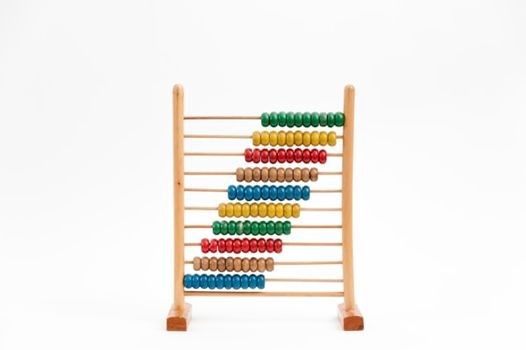

------------------------------ Start of response -------------------------------


A wooden abacus with colorful beads sits on a white background.

------------------------------- End of response --------------------------------



In [18]:
prompt = "Describe this image in a short sentence:"
# Image by Crissy Jarvis on Unsplash: https://unsplash.com/photos/cHhbULJbPwM
image_abacus = load_image_from_url(
    "https://unsplash.com/photos/cHhbULJbPwM/download?w=600"
)

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

… or ask specific questions:


----------------------------------- Contents -----------------------------------

Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?



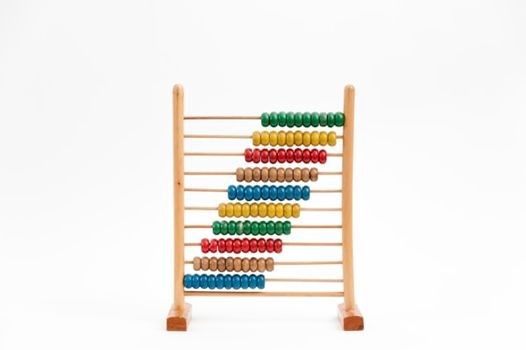

------------------------------ Start of response -------------------------------


```json
[
 {
  "question": "What does the image show?",
  "answer": "The image shows an abacus."
 },
 {
  "question": "How does it work?",
  "answer": "An abacus is a manual calculating device. It consists of beads that can be moved along rods or wires. The beads represent digits, and their positions determine the value of a number."
 },
 {
  "question": "When was it invented?",
  "answer": "The abacus was invented around 2400 BC in Mesopotamia."
 },
 {
  "question": "What's the name of this object in French, Italian, Spanish, Dutch, and German?",
  "answer": "The name of this object in different languages is:\n\n- French: boulier\n- Italian: abaco\n- Spanish: ábaco\n- Dutch: telraam\n- German: Abakus"
 },
 {
  "question": "What are the most prominent colors in the image?",
  "answer": "The most prominent colors in the image are brown, red, green, blue, and yellow."
 }
]
```

------------------------------- End of response --------------------------------



In [19]:
prompt = """
Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?
"""

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

Your specific questions can have follow-up questions:


----------------------------------- Contents -----------------------------------


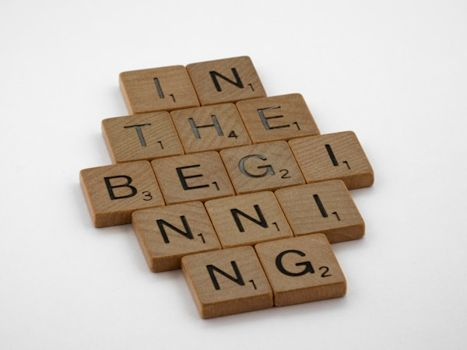


- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?

------------------------------ Start of response -------------------------------


- The expression is "IN THE BEGINNING". It is presented in the form of a word puzzle, using letter tiles arranged in a pyramid shape.

- The opposite expression is "IN THE END".

- **Using "IN THE BEGINNING":** "In the beginning of your exam, take a few deep breaths to calm your nerves and quickly skim through the questions to get an overview."

- **Using "IN THE END":** "In the end, what matters most is that you tried your best. Don't dwell on mistakes, learn from them and move forward."

------------------------------- End of response --------------------------------



In [20]:
# Image by Brett Jordan on Unsplash: https://unsplash.com/photos/E1por_SGvJE
image_tiles = load_image_from_url(
    "https://unsplash.com/photos/E1por_SGvJE/download?w=600"
)
prompt = """
- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?
"""

contents = [image_tiles, prompt]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

Information can have multiple forms. It can be objects, printed text, handwritten text, and more:


----------------------------------- Contents -----------------------------------

Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What color is it?
- What color is the formula?
- What's the object in the bottom?
- What can you conclude about the object?



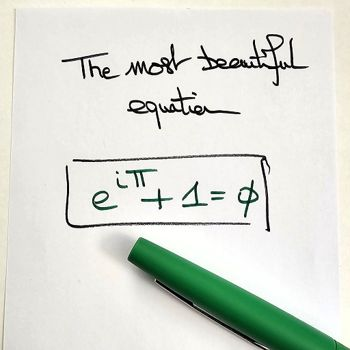

------------------------------ Start of response -------------------------------


| Instruction | Result |
|---|---|
| Extract the formula. | $e^{i\pi} + 1 = 0$ |
| What is the symbol right before Pi? What does it mean? | The symbol is *i*. It represents the imaginary unit,  $\sqrt{-1}$. |
| Is this a famous formula? Does it have a name? | Yes, it's often called Euler's Identity. |
| Why is it special? | It connects five fundamental constants in mathematics: e, i, π, 1, and 0. It's considered elegant due to this connection and its concise form. |
| Extract the caption. | The most beautiful equation |
| What color is it? | Black |
| What color is the formula? | Green |
| What's the object in the bottom? | A green pen. |
| What can you conclude about the object? | It was likely used to write the formula on the paper. |

------------------------------- End of response --------------------------------



In [21]:
prompt = """
Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What color is it?
- What color is the formula?
- What's the object in the bottom?
- What can you conclude about the object?
"""
image_euler = load_image_from_url(
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/math_beauty.jpg"
)

contents = [prompt, image_euler]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

You can also ask for interpretations and suggestions:


----------------------------------- Contents -----------------------------------

Answer the following questions about the image.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is visible?
- What are the reasons it's funny?
- What could be a fun caption?
- What could happen next?
- How would you alter the image? Would it still be funny and why?
- How would you make it funnier?



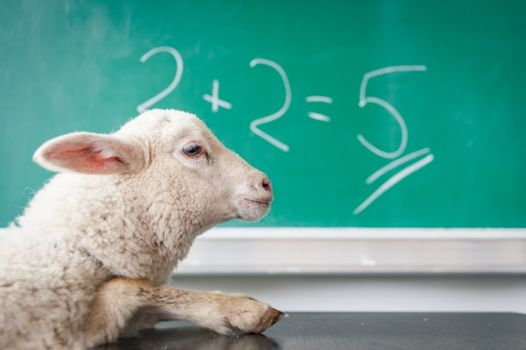

------------------------------ Start of response -------------------------------


## Analyzing the Sheep and the Chalkboard

| Question | Answer |
|---|---|
| What is visible? | A young lamb is sitting on a desk in front of a chalkboard. The chalkboard has the equation "2 + 2 = 5" written on it. |
| What are the reasons it's funny? | The humor comes from the juxtaposition of the innocent lamb with the obviously incorrect math equation. It plays on the idea of sheep being unintelligent and blindly following, implying the lamb accepts the wrong answer. |
| What could be a fun caption? |  * "New math curriculum is really something." * "Even sheep know this is wrong." * "Ba-a-ad math, anyone?" |
| What could happen next? |  * The lamb grabs a piece of chalk and tries to correct the equation. * A teacher walks in and looks at the board with a confused expression. * Another lamb walks up and writes "1+1= window" on the board. |
| How would you alter the image? Would it still be funny and why? |  * Instead of a lamb, use a different animal known for being smart, like a chimpanzee. This would still be funny because of the unexpectedness of an animal doing math, but it would change the humor from playing on sheep stereotypes. * Add a thought bubble above the lamb's head with a confused expression or question mark. This would emphasize the lamb's supposed confusion and enhance the humor. |
| How would you make it funnier? | * Have the lamb wearing glasses as if trying to understand the equation. * Add more sheep in the background, some looking confused, others nodding in agreement. * Change the equation to something even more nonsensical, like "1+1=banana." |

------------------------------- End of response --------------------------------



In [22]:
prompt = """
Answer the following questions about the image.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is visible?
- What are the reasons it's funny?
- What could be a fun caption?
- What could happen next?
- How would you alter the image? Would it still be funny and why?
- How would you make it funnier?
"""
# Image by Elimende Inagella on Unsplash: https://unsplash.com/photos/4ApmfdVo32Q
image_classroom = load_image_from_url(
    "https://unsplash.com/photos/4ApmfdVo32Q/download?w=600"
)

contents = [prompt, image_classroom]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

## Reasoning on multiple images


You can also use multiple images:


----------------------------------- Contents -----------------------------------

Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)

Image 1:


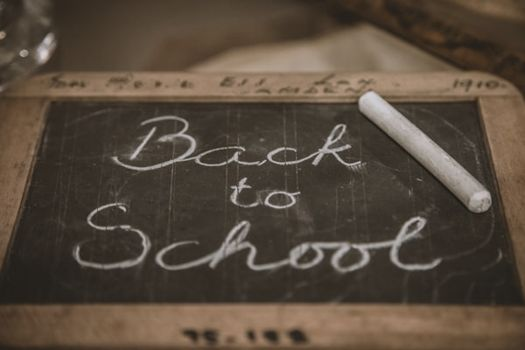

Image 2:


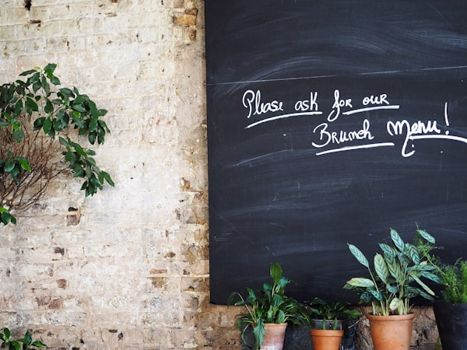

Image 3:


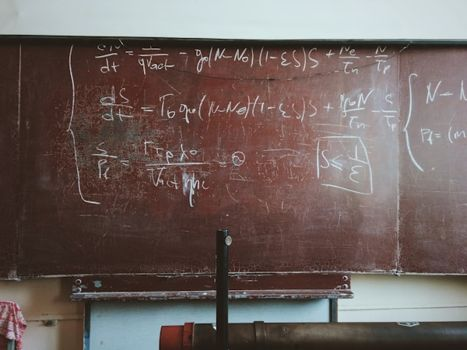

------------------------------ Start of response -------------------------------


## Image Analysis

| Image | What can we see in the image? | Where does it take place? |
|---|---|---|
| 1 | A chalkboard with "Back to School" written on it in chalk. | School |
| 2 | A chalkboard with "Please ask for our Brunch menu!" written on it, leaning against a brick wall with potted plants in front. | Restaurant |
| 3 | A chalkboard with complex mathematical formulas written on it. | Classroom |

------------------------------- End of response --------------------------------



In [23]:
prompt = f"""
Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)
"""
caption_b1 = "Image 1:"
caption_b2 = "Image 2:"
caption_b3 = "Image 3:"
# Photo by Deleece Cook on Unsplash: https://unsplash.com/photos/zzjLGF_6dx4
image_b1 = load_image_from_url("https://unsplash.com/photos/zzjLGF_6dx4/download?w=600")
# Photo by Natasha Kapur on Unsplash: https://unsplash.com/photos/ndAHi2Wxcok
image_b2 = load_image_from_url("https://unsplash.com/photos/ndAHi2Wxcok/download?w=600")
# Photo by Roman Mager on Unsplash: https://unsplash.com/photos/5mZ_M06Fc9g
image_b3 = load_image_from_url("https://unsplash.com/photos/5mZ_M06Fc9g/download?w=600")

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

… or make comparisons between images:


----------------------------------- Contents -----------------------------------

Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a mathematician?
- Which one indicates it's the end of vacation?
- Which one suggests we may get a coffee there?

Image 1:


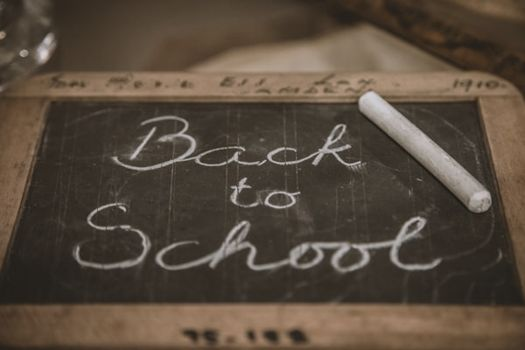

Image 2:


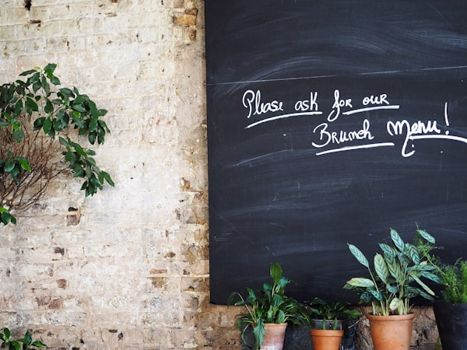

Image 3:


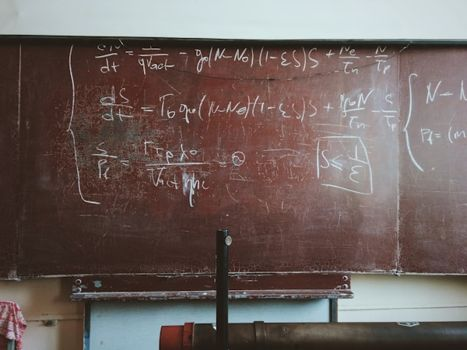

------------------------------ Start of response -------------------------------


## Image Analysis

| Question | Answer | Reason |
|---|---|---|
| What do the images have in common? | They all feature a chalkboard. | All three images depict a chalkboard as the central element. |
| Which one would be of interest to a mathematician? | Image 3 | Image 3 shows mathematical formulas and equations written on the chalkboard, making it relevant to a mathematician. |
| Which one indicates it's the end of vacation? | Image 1 | Image 1 displays the message "Back to School," signifying the end of summer vacation and the start of a new school year. |
| Which one suggests we may get a coffee there? | Image 2 | Image 2 advertises a "Brunch Menu," implying that the location likely serves coffee, a common brunch beverage. |

------------------------------- End of response --------------------------------



In [24]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a mathematician?
- Which one indicates it's the end of vacation?
- Which one suggests we may get a coffee there?
"""

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

You can use Gemini's level of language and visual understanding to work with concepts or even get suggestions on new images:


----------------------------------- Contents -----------------------------------

Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What does the first image represent?
- What does the second image represent?
- What could be the next logical image?

Image 1:


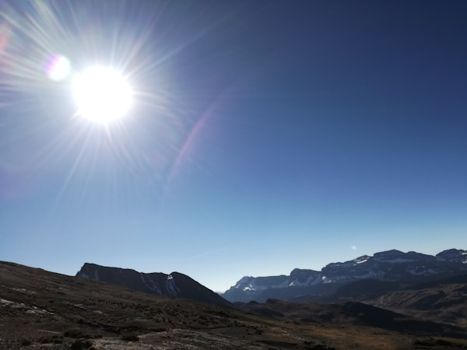

Image 2:


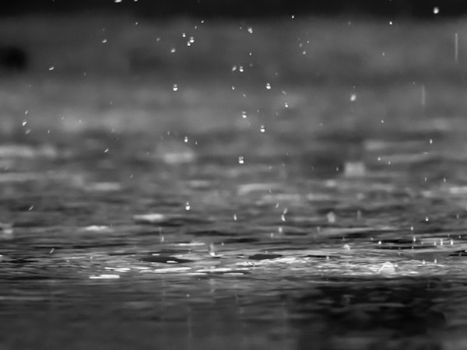

------------------------------ Start of response -------------------------------


## Image Interpretation

| Question | Answer | Reason |
|---|---|---|
| What does the first image represent? | Daytime | The image shows a bright sun in a clear blue sky, indicating daytime. |
| What does the second image represent? | Rainfall | The image shows water droplets falling and creating ripples on a surface, indicating rainfall. |
| What could be the next logical image? | A rainbow |  The sequence shows daytime followed by rain. A rainbow is a meteorological phenomenon that often appears after rain when the sun is still shining, making it a logical next image. |

------------------------------- End of response --------------------------------



In [25]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What does the first image represent?
- What does the second image represent?
- What could be the next logical image?
"""
caption_w1 = "Image 1:"
caption_w2 = "Image 2:"
# Photo by Diego Ballon Vargas on Unsplash: https://unsplash.com/photos/TA5bUTySOrg
image_w1 = load_image_from_url("https://unsplash.com/photos/TA5bUTySOrg/download?w=600")
# Photo by Reza Shayestehpour on Unsplash: https://unsplash.com/photos/Nw_D8v79PM4
image_w2 = load_image_from_url("https://unsplash.com/photos/Nw_D8v79PM4/download?w=600")

contents = [prompt, caption_w1, image_w1, caption_w2, image_w2]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

This is really up to your imagination:


----------------------------------- Contents -----------------------------------

Answer the following questions, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What theme do these images illustrate?
- What could be another image to replace the first one?
- What other image could replace the second one?
- What would be an alternative to the third image?
- And for the last one?

Image 1:


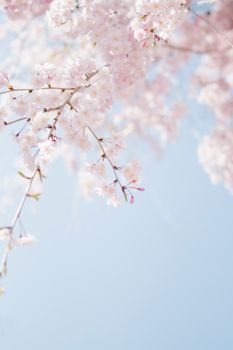

Image 2:


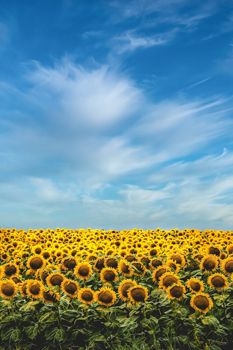

Image 3:


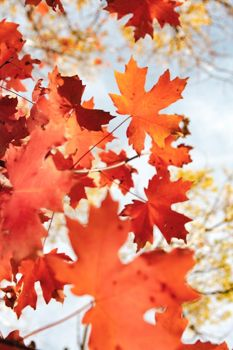

Image 4:


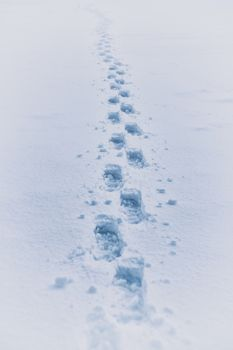

------------------------------ Start of response -------------------------------


## Image Theme and Alternatives

| Question | Answer | Reason |
|---|---|---|
| What theme do these images illustrate? | The four seasons | Each image represents a different season: spring (cherry blossoms), summer (sunflowers), autumn (fall leaves), and winter (footprints in the snow). |
| What could be another image to replace the first one? | A field of tulips | Tulips are another iconic flower that blooms in the spring, representing new beginnings and the vibrancy of the season. |
| What other image could replace the second one? | A beach scene with bright sun and blue skies | Beaches are strongly associated with summer, evoking warmth, sunshine, and relaxation. |
| What would be an alternative to the third image? | A pumpkin patch | Pumpkins are a quintessential symbol of autumn, often associated with harvest time and the changing colors of the season. |
| And for the last one? | A snow-covered landscape with bare trees | This image would further emphasize the stillness and cold of winter, highlighting the season's stark beauty. |

------------------------------- End of response --------------------------------



In [26]:
prompt = """
Answer the following questions, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What theme do these images illustrate?
- What could be another image to replace the first one?
- What other image could replace the second one?
- What would be an alternative to the third image?
- And for the last one?
"""
caption_s1 = "Image 1:"
caption_s2 = "Image 2:"
caption_s3 = "Image 3:"
caption_s4 = "Image 4:"
# Photo by Tomoko Uji on Unsplash: https://unsplash.com/photos/eriuKJwcdjI
image_s1 = load_image_from_url("https://unsplash.com/photos/eriuKJwcdjI/download?w=600")
# Photo by Todd Trapani on Unsplash: https://unsplash.com/photos/QldMpmrmWuc
image_s2 = load_image_from_url("https://unsplash.com/photos/QldMpmrmWuc/download?w=600")
# Photo by Olivia Hutcherson on Unsplash: https://unsplash.com/photos/rN3m7aTH3io
image_s3 = load_image_from_url("https://unsplash.com/photos/rN3m7aTH3io/download?w=600")
# Photo by Eberhard Grossgasteiger on Unsplash: https://unsplash.com/photos/FhdN5QVrBfY
image_s4 = load_image_from_url("https://unsplash.com/photos/FhdN5QVrBfY/download?w=600")

contents = [
    prompt,
    caption_s1,
    image_s1,
    caption_s2,
    image_s2,
    caption_s3,
    image_s3,
    caption_s4,
    image_s4,
]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

## Reasoning on a video


And you also can extract information from a video:


In [27]:
prompt = """
Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer, as well as the timestamps where the answer can be found and whether the info source comes from "Image", "Text", and/or "Speech".

QUESTIONS:
- Where was the video likely shot?
- What real animals are first visible as a group?
- What animals are cartoon characters doing a close-up selfie?
- What does the electronic device let real animals do?
- What is the veterinarian full name?
- Where does he work?
- What is Courtney's job position?
- What's her full name?
- Which famous brand is first visible?
- Which famous brand is last visible?
- What happens at timestamp 0:36?
- What happens at timestamp 1:05?
"""
video = Part.from_uri(
    uri="gs://cloud-samples-data/video/animals.mp4",
    mime_type="video/mp4",
)

contents = [prompt, video]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer, as well as the timestamps where the answer can be found and whether the info source comes from "Image", "Text", and/or "Speech".

QUESTIONS:
- Where was the video likely shot?
- What real animals are first visible as a group?
- What animals are cartoon characters doing a close-up selfie?
- What does the electronic device let real animals do?
- What is the veterinarian full name?
- Where does he work?
- What is Courtney's job position?
- What's her full name?
- Which famous brand is first visible?
- Which famous brand is last visible?
- What happens at timestamp 0:36?
- What happens at timestamp 1:05?



------------------------------ Start of response -------------------------------


| Question | Answer | Timestamp | Info Source |
|---|---|---|---|
| Where was the video likely shot? | Los Angeles Zoo | 0:15 | Image, Speech |
| What real animals are first visible as a group? | Giraffes | 0:19 | Image |
| What animals are cartoon characters doing a close-up selfie? | A fox and a rabbit | 0:14 | Image |
| What does the electronic device let real animals do? | Capture photos of themselves | 0:20 | Speech |
| What is the veterinarian full name? | Evan Antin | 0:57 | Text |
| Where does he work? | Conejo Valley Veterinary Hospital | 0:58 | Text |
| What is Courtney's job position? | Creative Strategist | 1:12 | Text |
| What's her full name? | Courtney Powell | 1:12 | Text |
| Which famous brand is first visible? | Google Photos | 0:05 | Image, Text |
| Which famous brand is last visible? | Disney | 1:33 | Image, Text |
| What happens at timestamp 0:36? | Two elephants are shown standing next to each other. | 0:36 | Image |
| What happens at timestamp 1:05? | An otter swims underwater. | 1:05 | Image |

------------------------------- End of response --------------------------------



Some remarks:

- Gemini uses both video and audio information.
  - Video files are sampled at 1 frame per second (1fps).
  - Video and audio samples are analyzed with their timestamps.
  - Text (typewritten or handwritten) can be detected in video frames, like when reasoning on images.
  - This explains why the extracted samples can give you three possible sources of information:
    - image (video frame)
    - text (text in the video frame)
    - speech (audio sample)
- Using timestamps, you can also ask questions about specific video locations.


## Conclusion

In this tutorial, you saw examples of how to use Gemini 1.5 in education to reason on text, images, and videos.

For more information, see the following documentation pages:

- [Image understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/image-understanding)
- [Video understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/video-understanding)
- [Audio understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/audio-understanding)
- [Document understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/document-understanding)

You may also want to explore other tutorials that focus on different domains or specificities of the Vertex AI Gemini API.
